## Generate Figure 4, for the sensitivity analysis manuscript 

In this notebook we generate the components needed to create figure 4 (and the related figure S3) in the sensitivity analysis manuscript. 

In particular, we examine the overall sensitivity measurements from the Hessian-based analysis (see Figure 2) as well as the individual parameter components while varying the light intensity levels over a given range. 

In [3]:
from copy import deepcopy
import numpy as np
import matplotlib.pyplot as plt
from jax import grad, jit, jacfwd, jacrev
import jax.numpy as jnp

# import the needed modules 
from hessian_normalized import HessianCircadian
from lightschedules import RegularLight
from lightschedules import ShiftWorkLight
from lightschedules import ShiftWorkerThreeTwelves
from lightschedules import SocialJetLag
from lightschedules import SlamShift

sens=HessianCircadian()
params = sens.get_parameters_array()

figure_save = 'off'

# define the light schedules 
ndays = 7
dt = 0.1
ts=np.arange(0, 24*ndays, dt)
intensity = 979
lights_rl = jnp.array([RegularLight(t, Intensity = intensity) for t in ts ]) # define the light schedules 
lights_sw = jnp.array([ShiftWorkLight(t,Intensity = intensity) for t in ts ])
lights_sw312 = jnp.array([ShiftWorkerThreeTwelves(t,Intensity = intensity) for t in ts ])
lights_sjl = jnp.array([SocialJetLag(t,Intensity = intensity) for t in ts ])
lights_ss = jnp.array([SlamShift(t,Intensity = intensity) for t in ts ])
lights_dark = jnp.zeros([len(ts),])

Below we compute the hessian matrix for each of the six light schedules (regular light, shift work, shift work three twelves, social jet lag, slam shift, and constant routine) and for a range of different realistic lighting levels. 

Specifically, we vary the light levels $I$ from $I = 0$ to $I = 950$ lux, in increments of $50$ lux. For each of these light level and light schedule combinations we store the eigenvalues and principle eigenvector of the hessian, for future analysis. 

In [ ]:
# generate the sensitivity hessian results 
def ics_individual_schedules(final_state_diff, convergence_val, ics, lights, params):
    u0 = ics
    count = 0
    while final_state_diff > convergence_val and count < 50:

        # simulate the model and extract the final time as the initial condition
        count = count + 1
        statesfinal = sens.step_n(u0 = u0, light = lights, params = params, dt = 0.10) # final state value
        final_state_diff = abs(statesfinal[0] - u0[0]) + abs(np.mod(statesfinal[1] - u0[1] + np.pi,2*np.pi) - np.pi)
        #print(final_state_diff)
        u0 = statesfinal
    return u0

# define parameters
convergence_val = 10**(-3)
final_state_diff = 100
num_iter = 20
norm_2 = np.zeros([6, num_iter])

# store the hessians eigenvectors and eigenvalues
evecs_rl_all = np.zeros([num_iter,len(params)])
evecs_sw_all = np.zeros([num_iter,len(params)])
evecs_sw312_all = np.zeros([num_iter,len(params)])
evecs_sjl_all = np.zeros([num_iter,len(params)])
evecs_ss_all = np.zeros([num_iter,len(params)])
evecs_dark_all = np.zeros([num_iter,len(params)])

evals_rl_all = np.zeros([num_iter,len(params)])
evals_sw_all = np.zeros([num_iter,len(params)])
evals_sw312_all = np.zeros([num_iter,len(params)])
evals_sjl_all = np.zeros([num_iter,len(params)])
evals_ss_all = np.zeros([num_iter,len(params)])
evals_dark_all = np.zeros([num_iter,len(params)])

# iterate through the light intensities of interest 
for j in range(num_iter):
    
    print(j)
    intensity = 50*(j)
    lights_rl = jnp.array([RegularLight(t, Intensity = intensity) for t in ts ]) # define the light schedules 
    lights_sw = jnp.array([ShiftWorkLight(t,Intensity = intensity) for t in ts ])
    lights_sw312 = jnp.array([ShiftWorkerThreeTwelves(t,Intensity = intensity) for t in ts ])
    lights_sjl = jnp.array([SocialJetLag(t,Intensity = intensity) for t in ts ])
    lights_ss = jnp.array([SlamShift(t,Intensity = intensity) for t in ts ])
    lights_dark = jnp.zeros([len(ts),])+intensity
    
    ics = jnp.array([0.70,0.0,0.0])
    ics_rl = ics_individual_schedules(final_state_diff, convergence_val, ics, lights_rl, params) # look into mod 2pi phase 
    ics_sw = ics_individual_schedules(final_state_diff, convergence_val, ics, lights_sw, params)
    ics_sw312 = ics_individual_schedules(final_state_diff, convergence_val, ics, lights_sw312, params)
    ics_sjl = ics_individual_schedules(final_state_diff, convergence_val, ics, lights_sjl, params)
    ics_ss = ics_individual_schedules(final_state_diff, convergence_val, ics, lights_ss, params)
    ics_dark = ics_individual_schedules(final_state_diff, convergence_val, ics, lights_dark, params)

    hessianVal_rl = sens.normalized_hessian(u0 = ics_rl,light = lights_rl)
    hessianVal_sw = sens.normalized_hessian(u0 = ics_sw,light = lights_sw)
    hessianVal_sw312 = sens.normalized_hessian(u0 = ics_sw312,light = lights_sw312)
    hessianVal_sjl = sens.normalized_hessian(u0 = ics_sjl,light = lights_sjl)
    hessianVal_ss = sens.normalized_hessian(u0 = ics_ss,light = lights_ss)
    hessianVal_dark = sens.normalized_hessian(u0 = ics_dark,light = lights_dark)
    
    # store the hessian eigenvalues and eigenvectors
    evals_rl, evecs_rl = np.linalg.eig(hessianVal_rl)
    evecs_prin_rl = evecs_rl[:,np.argmax(evals_rl)]
    evecs_rl_all[j,:] = evecs_prin_rl
    evals_rl_all[j,:] = evals_rl
    evals_sw, evecs_sw = np.linalg.eig(hessianVal_sw)
    evecs_prin_sw = evecs_sw[:,np.argmax(evals_sw)]
    evecs_sw_all[j,:] = evecs_prin_sw
    evals_sw_all[j,:] = evals_sw
    evals_sw312, evecs_sw312 = np.linalg.eig(hessianVal_sw312)
    evecs_prin_sw312 = evecs_sw312[:,np.argmax(evals_sw312)]
    evecs_sw312_all[j,:] = evecs_prin_sw312
    evals_sw312_all[j,:] = evals_sw312
    evals_sjl, evecs_sjl = np.linalg.eig(hessianVal_sjl)
    evecs_prin_sjl = evecs_sjl[:,np.argmax(evals_sjl)]
    evecs_sjl_all[j,:] = evecs_prin_sjl
    evals_sjl_all[j,:] = evals_sjl
    evals_ss, evecs_ss = np.linalg.eig(hessianVal_ss)
    evecs_prin_ss = evecs_ss[:,np.argmax(evals_ss)]
    evecs_ss_all[j,:] = evecs_prin_ss
    evals_ss_all[j,:] = evals_ss
    evals_dark, evecs_dark = np.linalg.eig(hessianVal_dark)
    evecs_prin_dark = evecs_dark[:,np.argmax(evals_dark)]
    evecs_dark_all[j,:] = evecs_prin_dark
    evals_dark_all[j,:] = evals_dark
    

    norm_2[0,j] = np.linalg.norm(hessianVal_rl)
    norm_2[1,j]  = np.linalg.norm(hessianVal_sw)
    norm_2[2,j] = np.linalg.norm(hessianVal_sw312)
    norm_2[3,j] = np.linalg.norm(hessianVal_sjl)
    norm_2[4,j] = np.linalg.norm(hessianVal_ss)
    norm_2[5,j] = np.linalg.norm(hessianVal_dark)


The code and cell above is computationally expensive. For convenience we store the eigenvectors and eigenvalues below.

In [ ]:
# process and store the dlmo sensitivity results 
from numpy import savetxt

savetxt('evecs_rl_all.csv', evecs_rl_all, delimiter=',')
savetxt('evecs_sw_all.csv', evecs_sw_all, delimiter=',')
savetxt('evecs_sw312_all.csv', evecs_sw312_all, delimiter=',')
savetxt('evecs_sjl_all.csv', evecs_sjl_all, delimiter=',')
savetxt('evecs_ss_all.csv', evecs_ss_all, delimiter=',')
savetxt('evecs_dark_all.csv', evecs_dark_all, delimiter=',')

savetxt('evals_rl_all.csv', evals_rl_all, delimiter=',')
savetxt('evals_sw_all.csv', evals_sw_all, delimiter=',')
savetxt('evals_sw312_all.csv', evals_sw312_all, delimiter=',')
savetxt('evals_sjl_all.csv', evals_sjl_all, delimiter=',')
savetxt('evals_ss_all.csv', evals_ss_all, delimiter=',')
savetxt('evals_dark_all.csv', evals_dark_all, delimiter=',')



In [4]:
# read in the data (saved above) 
import pandas as pd 

evecs_rl_all = pd.read_csv('data_resubmission/evecs_rl_all.csv', header = None)
evecs_rl_all = np.array(evecs_rl_all)

evecs_sw_all = pd.read_csv('data_resubmission/evecs_sw_all.csv', header = None)
evecs_sw_all = np.array(evecs_sw_all)

evecs_sw312_all = pd.read_csv('data_resubmission/evecs_sw312_all.csv', header = None)
evecs_sw312_all = np.array(evecs_sw312_all)

evecs_sjl_all = pd.read_csv('data_resubmission/evecs_sjl_all.csv', header = None)
evecs_sjl_all = np.array(evecs_sjl_all)

evecs_ss_all = pd.read_csv('data_resubmission/evecs_ss_all.csv', header = None)
evecs_ss_all = np.array(evecs_ss_all)

evecs_dark_all = pd.read_csv('data_resubmission/evecs_dark_all.csv', header = None)
evecs_dark_all = np.array(evecs_dark_all)

# eigenvalues 
evals_rl_all = pd.read_csv('data_resubmission/evals_rl_all.csv', header = None)
evals_rl_all = np.array(evals_rl_all)

evals_sw_all = pd.read_csv('data_resubmission/evals_sw_all.csv', header = None)
evals_sw_all = np.array(evals_sw_all)

evals_sw312_all = pd.read_csv('data_resubmission/evals_sw312_all.csv', header = None)
evals_sw312_all = np.array(evals_sw312_all)

evals_sjl_all = pd.read_csv('data_resubmission/evals_sjl_all.csv', header = None)
evals_sjl_all = np.array(evals_sjl_all)

evals_ss_all = pd.read_csv('data_resubmission/evals_ss_all.csv', header = None)
evals_ss_all = np.array(evals_ss_all)

evals_dark_all = pd.read_csv('data_resubmission/evals_dark_all.csv', header = None)
evals_dark_all = np.array(evals_dark_all)

After loading the stored data in the cell above, we visualize the overall hessian-based results for the six different light schedules and the twenty different lighting levels below. 

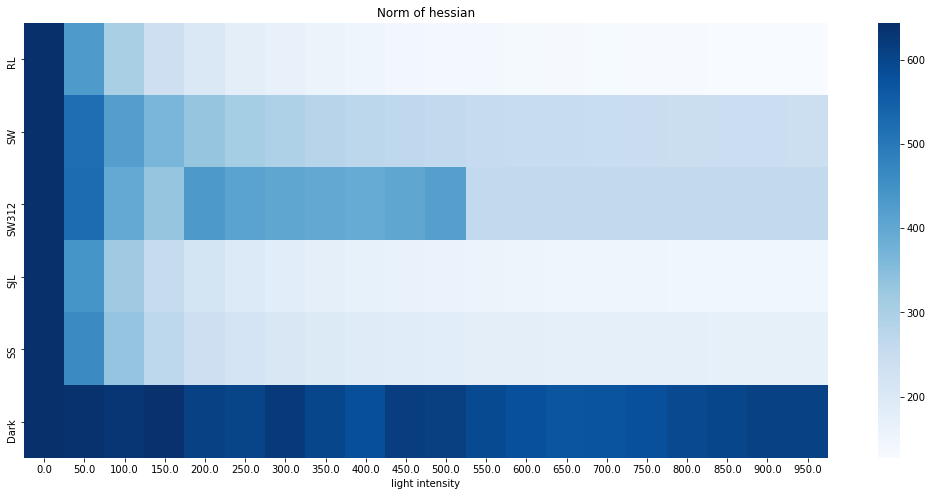

In [5]:
import seaborn as sns 
xvals = np.linspace(0,950,20)
evals_rl_max = np.zeros([len(evals_rl_all[:,0])])
evals_sw_max = np.zeros([len(evals_sw_all[:,0])])
evals_sw312_max = np.zeros([len(evals_sw312_all[:,0])])
evals_ss_max = np.zeros([len(evals_ss_all[:,0])])
evals_sjl_max = np.zeros([len(evals_sjl_all[:,0])])
evals_dark_max = np.zeros([len(evals_dark_all[:,0])])

for j in range(len(evals_rl_all[:,0])):
    
    evals_rl_max[j] = np.max(abs(evals_rl_all[j,:]))
    evals_sw_max[j] = np.max(abs(evals_sw_all[j,:]))
    evals_sw312_max[j] = np.max(abs(evals_sw312_all[j,:]))
    evals_sjl_max[j] = np.max(abs(evals_sjl_all[j,:]))
    evals_ss_max[j] = np.max(abs(evals_ss_all[j,:]))
    evals_dark_max[j] = np.max(abs(evals_dark_all[j,:]))
    

overall_spectral_norm = np.zeros([6,len(evals_rl_max)])
overall_spectral_norm[0,:] = evals_rl_max
overall_spectral_norm[1,:] = evals_sw_max
overall_spectral_norm[2,:] = evals_sw312_max
overall_spectral_norm[3,:] = evals_sjl_max
overall_spectral_norm[4,:] = evals_ss_max
overall_spectral_norm[5,:] = evals_dark_max
plt.figure(figsize = (18,8))
ax = sns.heatmap(overall_spectral_norm,annot = False, cmap = 'Blues')
ax.set_yticklabels(['RL','SW','SW312','SJL','SS','Dark'])
#ax.set_xticklabels(['']*20)
ax.set_xticklabels(xvals)
ax.set_title('Norm of hessian')
ax.set_xlabel('light intensity')
if figure_save == 'on':
    plt.savefig('figures_resubmission/norm_hessian_intensity_hm.svg')
plt.show()

Now we examine some of the individual parameter components of interest. We iterate through the parameters and visualize the changes in the eigenvector component as we increase the lighting intensity across the different schedules. 

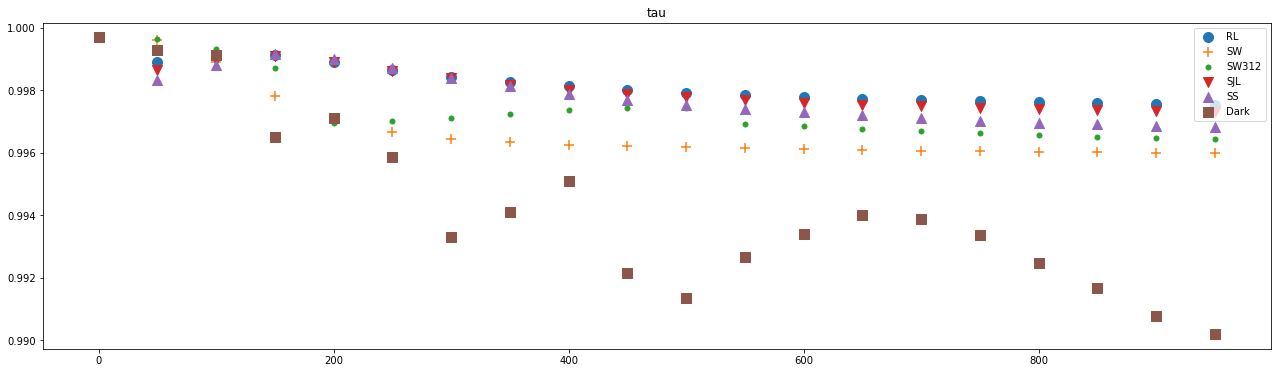

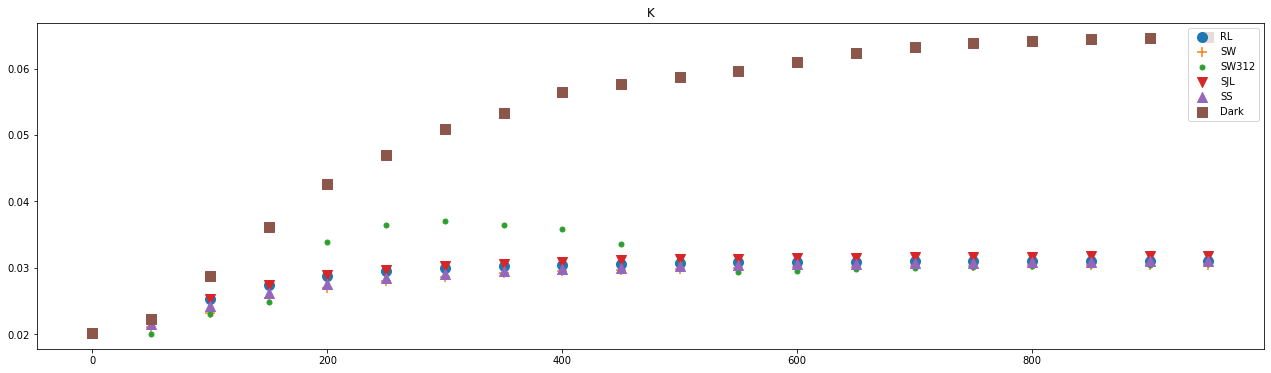

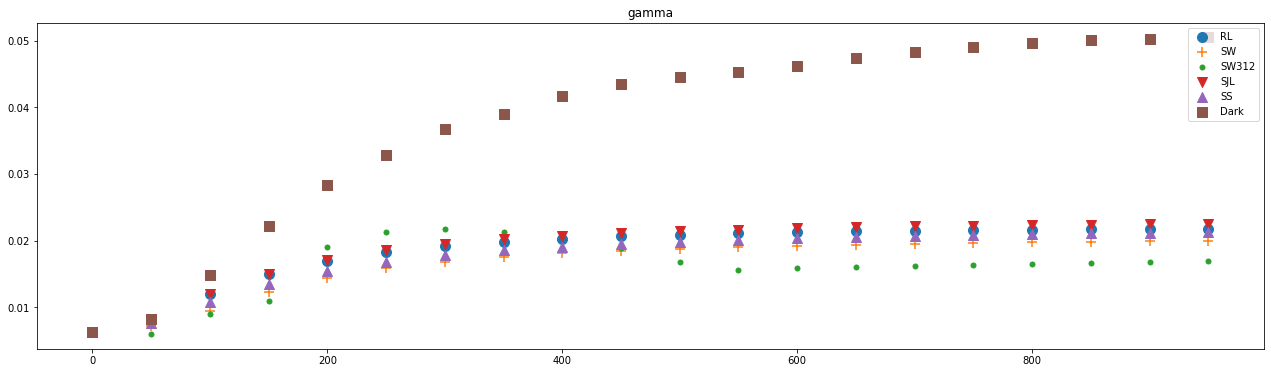

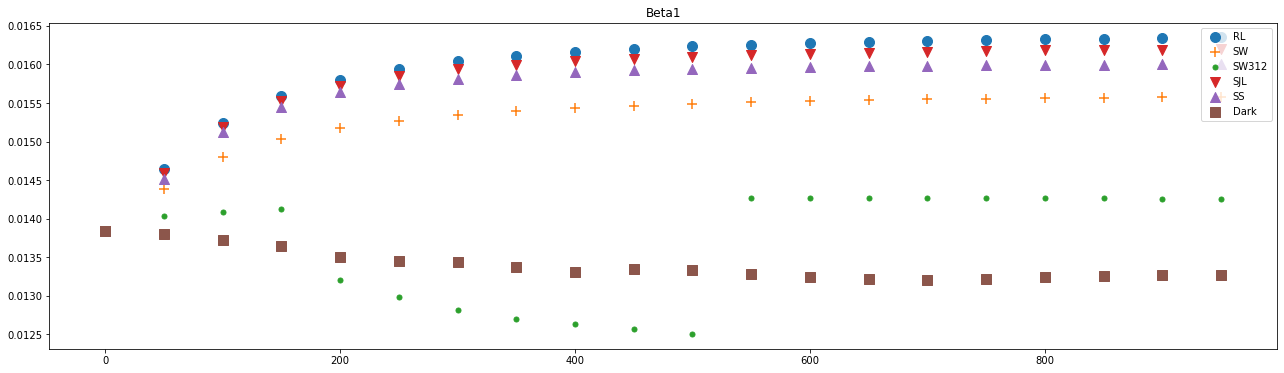

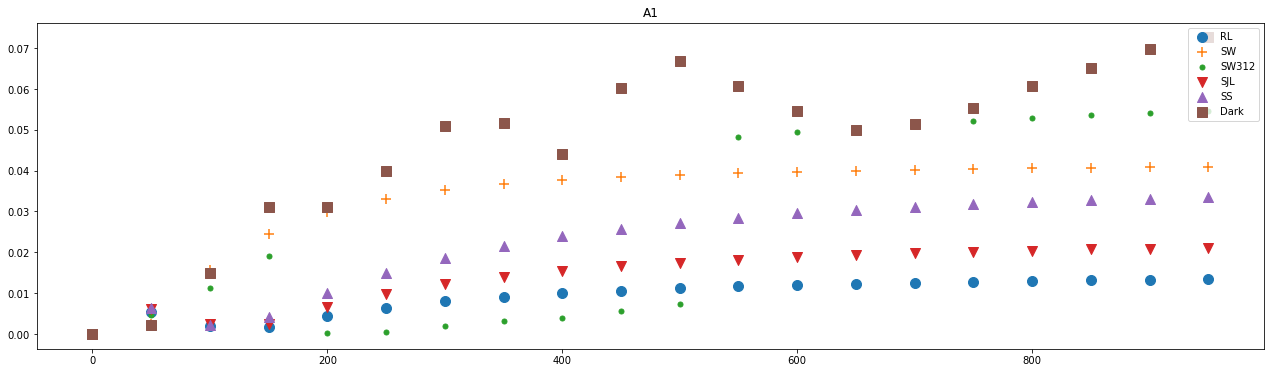

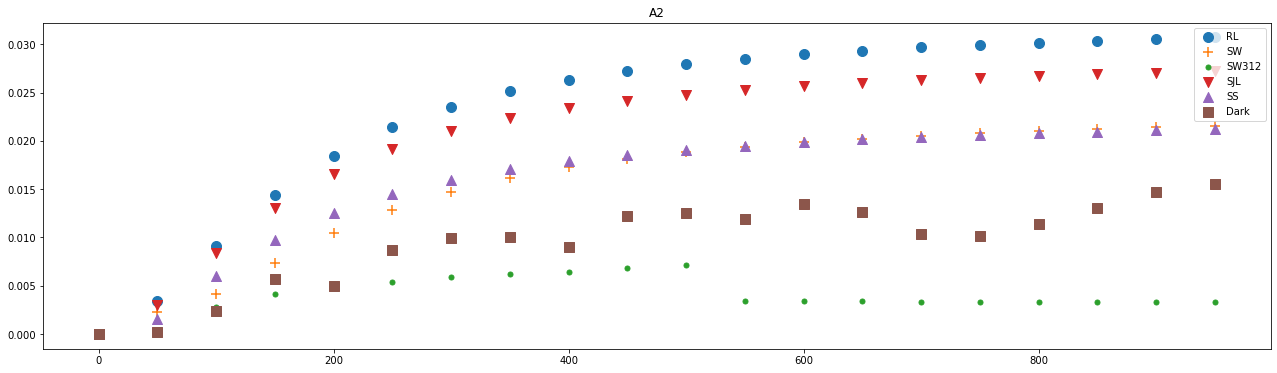

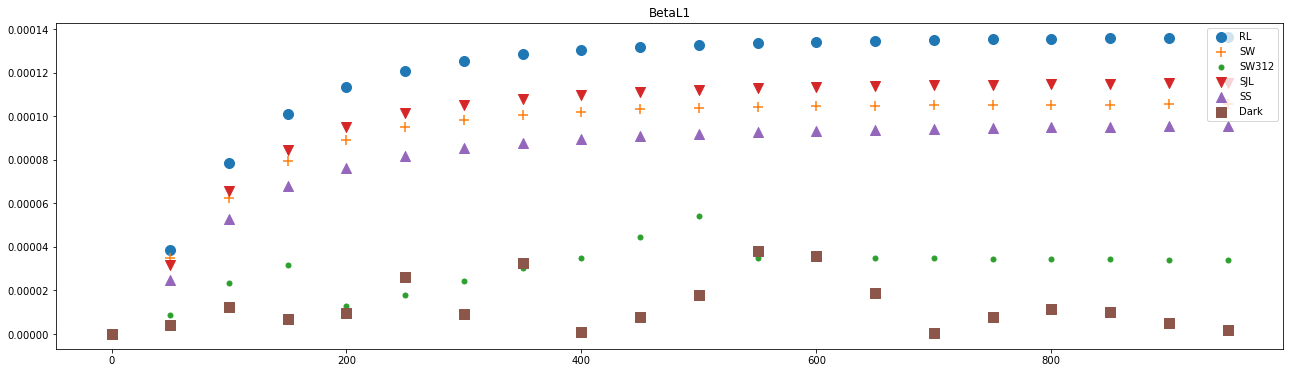

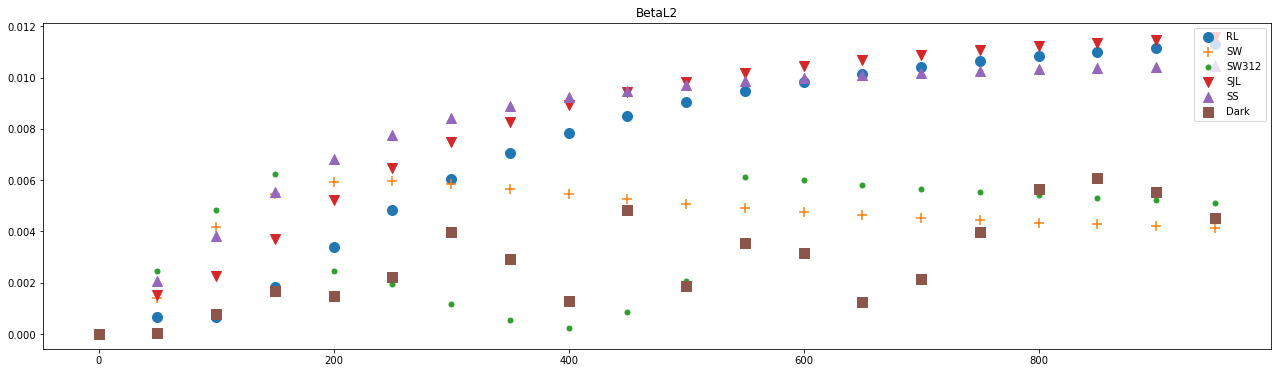

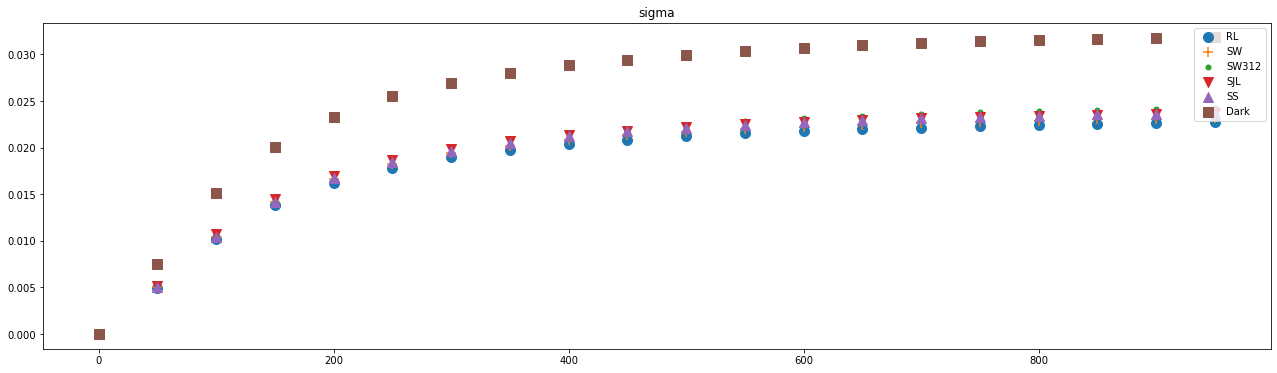

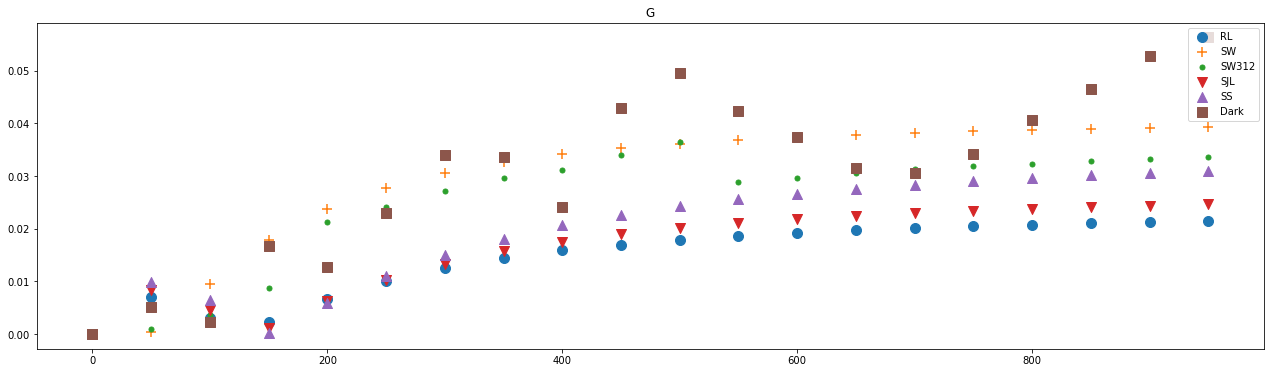

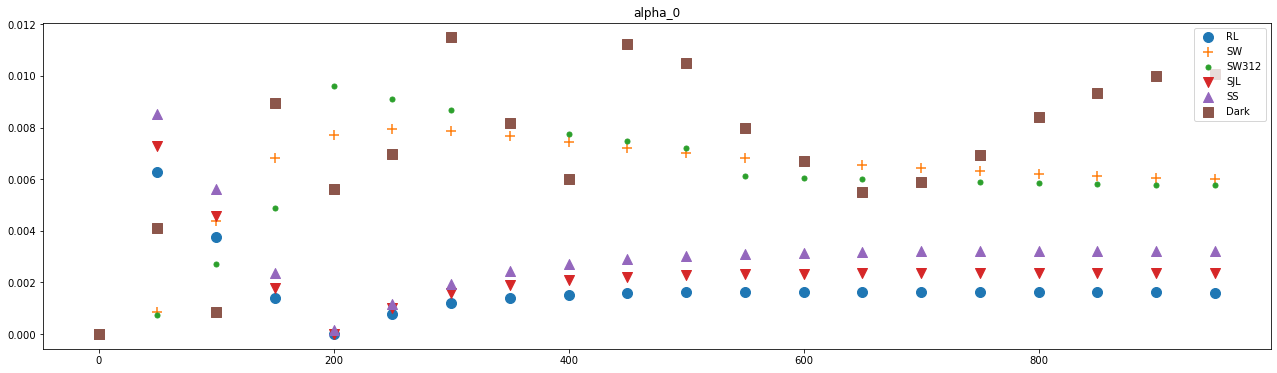

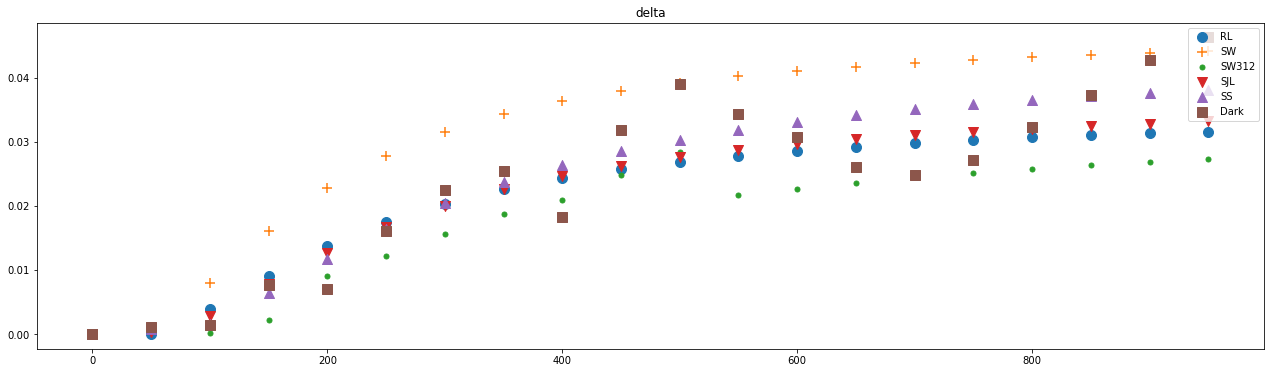

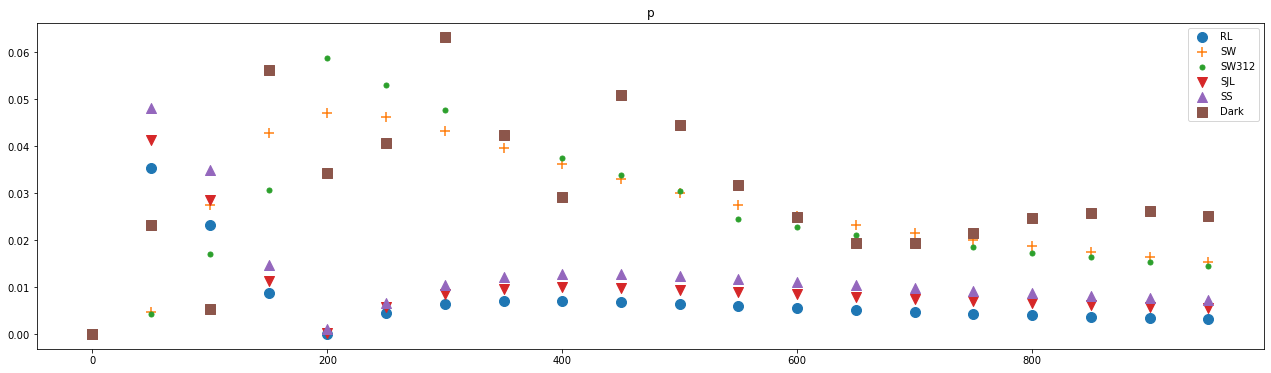

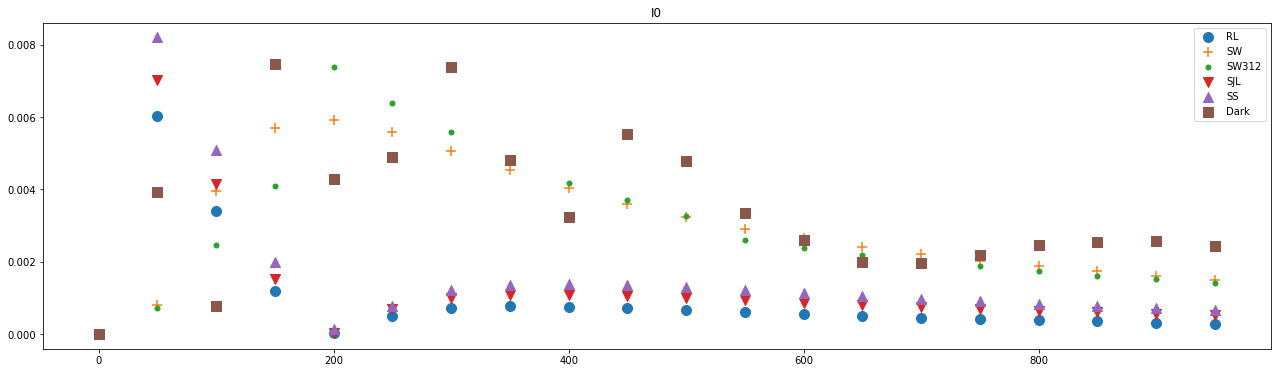

In [6]:
# different figure version: one plot for each parameter 
labels = ['tau', 'K', 'gamma', 'Beta1', 'A1', 'A2', 'BetaL1',
                  'BetaL2', 'sigma', 'G', 'alpha_0', 'delta', 'p', 'I0']
schedules = ['RL','SW','SW312','SJL','SS','Dark']
for j in range(len(evecs_rl_all[0,:])):
    plt.figure(figsize = (22,6))
    plt.scatter(xvals, abs(evecs_rl_all[:,j]),marker='o', s = 100)
    plt.scatter(xvals, abs(evecs_sw_all[:,j]),marker='+',s = 100)
    plt.scatter(xvals, abs(evecs_sw312_all[:,j]), marker='.',s = 100)
    plt.scatter(xvals, abs(evecs_sjl_all[:,j]),marker='v',s = 100)
    plt.scatter(xvals, abs(evecs_ss_all[:,j]),marker='^',s = 100)
    plt.scatter(xvals, abs(evecs_dark_all[:,j]),marker = 's',s = 100)
    plt.title(labels[j])
    plt.legend(schedules, loc = 'upper right')
    if figure_save == 'on':
        plt.savefig('figures_resubmission/supp_light_levels_individual_params_' + labels[j] + '.svg')